# Codebuster STAT 535 Statistical Computing Project
## Movie recommendation recommendation pipeline

##### Patrick's comments 11/9

- Goal: Build a small real world deployment pipeline like it can be used in netflix / amazon 
- build / test with movie recommendation data set (model fitting, data preprocessing, evaluation)
- Show that it also works with another dataset like product recommendation
 - Find data on UCI repo, kaggle, google search 

- Use scikit learn estimation: https://github.com/scikit-learn-contrib/project-template


## Literature

- https://users.ece.cmu.edu/~dbatra/publications/assets/goel_batra_netflix.pdf
- http://delivery.acm.org/10.1145/1460000/1454012/p11-park.pdf?ip=72.19.68.210&id=1454012&acc=ACTIVE%20SERVICE&key=73B3886B1AEFC4BB%2EB478147E31829731%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1543416754_7f92e0642e26e7ea732886879096c704
- https://www.kaggle.com/prajitdatta/movielens-100k-dataset/kernels
- https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223
- https://www.kaggle.com/c/predict-movie-ratings
- https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a048.pdf
- https://github.com/neilsummers/predict_movie_ratings/blob/master/movieratings.py
- https://medium.com/@connectwithghosh/recommender-system-on-the-movielens-using-an-autoencoder-using-tensorflow-in-python-f13d3e8d600d
### A few more
- https://sci2s.ugr.es/keel/pdf/specific/congreso/xia_dong_06.pdf (Uses SMV for classification, then MF for recommendation)
- https://www.kaggle.com/rounakbanik/movie-recommender-systems (Employs at least three Modules for recommendation)
- http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.703.4954&rep=rep1&type=pdf (Close to what we need, but a little too involving)
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0165868 (Uses SVM and correlation matrices...I have already tried the correlation approach, looks quite good, but how to quantify accuracy?)
- https://www.quora.com/How-do-we-use-SVMs-in-a-collaborative-recommendation (A good thread on SVM)
-http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/ (A good tutorial on matrix factorizasion)

## Approach

##### User cases: 
- ##### Case 0 rated movies: Supervised prediction with just user age, gender, and year of the movie
In case of cold-start: No user information available

- ##### Case < 10 rated movies: Content-based recommender system
Content-based recommendation information about users and their taste. As we can see in the preprocessing, most of the users only rated one to five movies, implying that we have incomplete user-profiles. I think content-based recommendation makes sense here, because we can recommend similar movies, but not other categories that a user might like because we can not identify similar users with an incomplete user profile.

- ##### Case >=10 rated movies:  Item-Item based collaborative recommender system
Collaborative filtering makes sense if you have a good user profile, which we assume we have if a user rated more or equal than 10 movies. With a good user profile we can identify similar users and make more sophisticated recommendations, e.g. movies from other genres.



In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import interp

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc

## Data Preprocessing
Get a feeling for the dataset, its problems and conduct helpful preprocessing

In [2]:
df = pd.read_csv("allData.tsv", sep='\t')
print(f"Shape: {df.shape}")
df.head()

Shape: (31620, 10)


,userID,age,gender,movieID,name,year,genre1,genre2,genre3,rating
0,747,1,F,1193,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,5
1,747,1,F,661,James and the Giant Peach,1996,Animation,Children's,Musical,3
2,747,1,F,2804,"Christmas Story, A",1983,Comedy,Drama,NaN,5
3,747,1,F,919,"Wizard of Oz, The",1939,Adventure,Children's,Drama,4
4,747,1,F,2791,Airplane!,1980,Comedy,NaN,NaN,4


In [3]:
df.age.value_counts()

25    11767
18     6660
35     6299
45     2481
50     2400
56     1021
1       992
Name: age, dtype: int64

##### Histogram: Number of movies are rated by users
Most users rated only up tp 5 movies

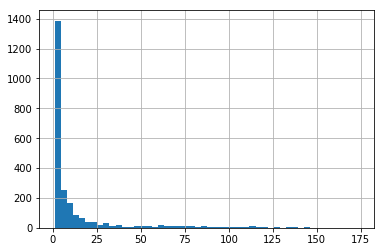

In [4]:
df.userID.value_counts().hist(bins=50)

##### Filter out users with more than 10 ratings -> good user profile
It can be useful to use content-based recommender systems for those users

In [5]:
# count of users with > 10 ratings
df_content = df.copy()
df_content.set_index('userID', inplace=True)

df_content[df.userID.value_counts()>10].shape


/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


(26498, 9)

In [8]:
df_content.groupby('userID').count().movieID.sort_values().head()

userID
2992    1
3762    1
1607    1
3758    1
3755    1
Name: movieID, dtype: int64

In [9]:
df.dtypes

userID      int64
age         int64
gender     object
movieID     int64
name       object
year        int64
genre1     object
genre2     object
genre3     object
rating      int64
dtype: object

##### Handle categorical and missing data

##### Transform numerical rating to binary
- 1, if user rates movie 4 or 5
- 0, if user rates movie less than 4

In [10]:
df['rating'].mask(df['rating'] < 4, 0, inplace=True)
df['rating'].mask(df['rating'] > 3, 1, inplace=True)

##### Check rating distribution

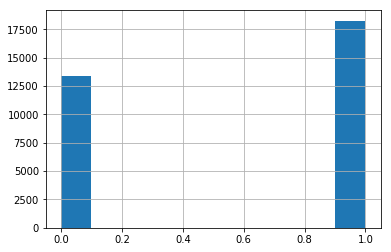

In [11]:
df['rating'].hist()

## Recommendation

##### Cold start: Gradient Boosting Classifier

In [33]:
# Cross Validation to test and anticipate overfitting problem
def crossvalidate(clf, X,y):
    scores1 = cross_val_score(clf, X, y, cv=10, scoring='precision')
    scores2 = cross_val_score(clf, X, y, cv=10, scoring='recall')
    scores3 = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix

In [34]:
# Run classifier with cross-validation and plot ROC curves
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def get_crossval_roc(clfname, classifier,X,y):
    '''
    Run classifier with cross-validation and plot ROC curves
    '''
    n_samples, n_features = X.shape
    
    cv = StratifiedKFold(n_splits=6)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return

In [36]:
# User information before any movie ratings
X = df[['age', 'gender', 'year']]
y = df['rating'].as_matrix()

# Preprocessing
# One hot encoding
dummyvars = pd.get_dummies(X['gender'])
# append the dummy variables to df
X = pd.concat([X[['age', 'year']], dummyvars], axis = 1).as_matrix()

GradientBoostingClassifier
Cross Validation Precision: 0.58 (+/- 0.00)
Cross Validation Recall: 0.94 (+/- 0.04)
Cross Validation roc_auc: 0.57 (+/- 0.02)


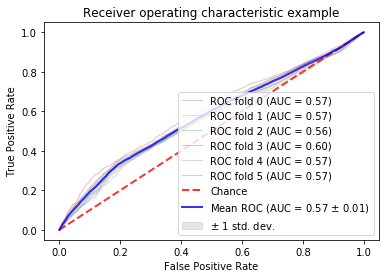

In [37]:
print("GradientBoostingClassifier")
gbclf = GradientBoostingClassifier(n_estimators=100)
crossvalidate(gbclf,X,y)
get_crossval_roc("gbclf",gbclf,X,y)

##### < 10 rated movies: Content-based recommendation with tf-idf
Inspired by: https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223

## Evaluation
10-fold Cross-validation

## Ceate predictions for predict.csv